# Synthetic Customer Churn Dataset — Description & Project Summary

Dataset source: generated via `generate_synthetic_churn()` (default n=5000).  
Purpose: provide a realistic, synthetic dataset to practice EDA, feature engineering and churn prediction modeling.

## Variables and descriptions
- customerID: unique customer identifier (string)
- gender: customer gender ("Male"/"Female")
- SeniorCitizen: binary indicator (0/1) for senior status
- Partner: whether customer has a partner ("Yes"/"No")
- Dependents: whether customer has dependents ("Yes"/"No")
- tenure: number of months the customer has been with the provider (int)
- PhoneService: whether phone service is active ("Yes"/"No")
- MultipleLines: multiple phone lines ("Yes"/"No"/"No phone service")
- InternetService: type of internet service ("DSL"/"Fiber optic"/"No")
- OnlineSecurity: online security add-on ("Yes"/"No"/"No internet service")
- OnlineBackup: online backup add-on ("Yes"/"No"/"No internet service")
- DeviceProtection: device protection add-on ("Yes"/"No"/"No internet service")
- TechSupport: technical support add-on ("Yes"/"No"/"No internet service")
- StreamingTV: streaming TV add-on ("Yes"/"No"/"No internet service")
- StreamingMovies: streaming movies add-on ("Yes"/"No"/"No internet service")
- Contract: contract type ("Month-to-month"/"One year"/"Two year")
- PaperlessBilling: whether billing is paperless ("Yes"/"No")
- PaymentMethod: payment method (e.g. "Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)")
- MonthlyCharges: current monthly charge (float)
- TotalCharges: cumulative charges to date (float; may be 0 for tenure=0)
- Churn: target variable ("Yes"/"No")

Notes:
- A few columns include realistic missingness (e.g., OnlineSecurity, PaymentMethod, TotalCharges).
- Categorical values include special "No internet service"/"No phone service" categories to mimic real telco data.

## Project summary and goal
Goal: build a predictive model that classifies whether a customer will churn (Churn = "Yes") using customer demographics, services, billing and payment features.



You can inspect the generated data with:

In [12]:
# Cell to create synthetic Customer Churn dataset (place at index 0)
import numpy as np
import pandas as pd

def generate_synthetic_churn(n_customers=5000, seed=42, save_csv=True, csv_path="synthetic_churn.csv"):
    np.random.seed(seed)
    n = n_customers

    # IDs
    customer_id = [f"CUST{idx:06d}" for idx in range(1, n+1)]

    # Demographics
    gender = np.random.choice(["Male", "Female"], size=n, p=[0.48, 0.52])
    senior = np.random.binomial(1, 0.16, size=n)  # ~16% seniors
    partner = np.where(np.random.rand(n) < 0.45, "Yes", "No")
    dependents = np.where(np.random.rand(n) < 0.20, "Yes", "No")

    # Tenure: mixture (many new customers)
    tenure = np.concatenate([
        np.random.randint(0, 6, size=int(n * 0.45)),      # 0-5 months
        np.random.randint(6, 24, size=int(n * 0.25)),     # 6-23
        np.random.randint(24, 61, size=int(n * 0.20)),    # 24-60
        np.random.randint(61, 73, size=n - int(n * 0.45) - int(n * 0.25) - int(n * 0.20))
    ])
    np.random.shuffle(tenure)

    # Services
    phone_service = np.where(np.random.rand(n) < 0.92, "Yes", "No")
    multiple_lines = np.where(phone_service == "No", "No phone service",
                              np.where(np.random.rand(n) < 0.25, "Yes", "No"))

    internet_service = np.random.choice(["DSL", "Fiber optic", "No"], size=n, p=[0.30, 0.45, 0.25])
    def internet_feature(col_prob):
        return np.array([("No internet service" if svc == "No" else ("Yes" if np.random.rand() < p else "No"))
                         for svc, p in zip(internet_service, np.full(n, col_prob))])
    online_security = internet_feature(0.25)
    online_backup = internet_feature(0.20)
    device_protection = internet_feature(0.18)
    tech_support = internet_feature(0.18)
    streaming_tv = internet_feature(0.22)
    streaming_movies = internet_feature(0.22)

    # Contract, billing, payment
    contract = np.random.choice(["Month-to-month", "One year", "Two year"], size=n, p=[0.55, 0.25, 0.20])
    paperless = np.where(np.random.rand(n) < (0.75 * (contract == "Month-to-month") + 0.4 * (contract != "Month-to-month")), "Yes", "No")
    payment_method = np.random.choice(
        ["Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"],
        size=n,
        p=[0.36, 0.20, 0.22, 0.22]
    )

    # Monthly charges: base + service-driven add-ons
    base_charge = np.random.normal(20, 5, size=n)  # base monthly
    svc_count = (phone_service == "Yes").astype(int) + (internet_service != "No").astype(int) \
                + (streaming_tv == "Yes").astype(int) + (streaming_movies == "Yes").astype(int)
    svc_charge = svc_count * np.random.normal(15, 4, size=n)
    # fiber customers often pay more
    fiber_extra = np.where(internet_service == "Fiber optic", np.random.normal(20, 5, size=n), 0)
    monthly_charges = np.clip(base_charge + svc_charge + fiber_extra + np.random.normal(0, 5, size=n), 8.0, 200.0).round(2)

    # Total charges (may have small inconsistencies)
    total_charges = (monthly_charges * tenure + np.random.normal(0, 15, size=n)).round(2)
    total_charges = np.where(tenure == 0, 0.0, total_charges)
    total_charges = np.clip(total_charges, 0.0, None)

    # Compute churn probability using a logistic model (realistic drivers)
    # Features that increase churn: short tenure, month-to-month contract, high monthly charges, paperless, electronic check
    is_m2m = (contract == "Month-to-month").astype(int)
    is_echeck = (payment_method == "Electronic check").astype(int)
    no_internet = (internet_service == "No").astype(int)

    logit = (
        -2.0
        + 0.04 * monthly_charges
        - 0.035 * tenure
        + 1.25 * is_m2m
        + 0.45 * (paperless == "Yes").astype(int)
        + 0.6 * is_echeck
        + 0.25 * senior
        - 0.4 * (contract == "Two year").astype(int)
        - 0.2 * (internet_service == "Fiber optic").astype(int)  # maybe fiber users less likely to churn if bundled
    )
    prob_churn = 1 / (1 + np.exp(-logit))
    churn = np.where(np.random.rand(n) < prob_churn, "Yes", "No")

    # Assemble DataFrame
    df = pd.DataFrame({
        "customerID": customer_id,
        "gender": gender,
        "SeniorCitizen": senior,
        "Partner": partner,
        "Dependents": dependents,
        "tenure": tenure,
        "PhoneService": phone_service,
        "MultipleLines": multiple_lines,
        "InternetService": internet_service,
        "OnlineSecurity": online_security,
        "OnlineBackup": online_backup,
        "DeviceProtection": device_protection,
        "TechSupport": tech_support,
        "StreamingTV": streaming_tv,
        "StreamingMovies": streaming_movies,
        "Contract": contract,
        "PaperlessBilling": paperless,
        "PaymentMethod": payment_method,
        "MonthlyCharges": monthly_charges,
        "TotalCharges": total_charges,
        "Churn": churn
    })

    # Introduce a few missing values to mimic real data
    for col in ["TotalCharges", "OnlineSecurity", "PaymentMethod"]:
        mask = np.random.rand(n) < 0.01
        df.loc[mask, col] = np.nan

    if save_csv:
        df.to_csv(csv_path, index=False)

    return df

# Generate and show a small sample
if __name__ == "__main__":
    df = generate_synthetic_churn(n_customers=5000, seed=123)
    print("Generated synthetic churn dataset:", df.shape)
    print(df.head(8))

Generated synthetic churn dataset: (5000, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  CUST000001  Female              0      No         No      66          Yes   
1  CUST000002    Male              0      No         No      67          Yes   
2  CUST000003    Male              0      No         No      33          Yes   
3  CUST000004  Female              0     Yes         No       3          Yes   
4  CUST000005  Female              0     Yes         No      71          Yes   
5  CUST000006    Male              0     Yes        Yes      40          Yes   
6  CUST000007  Female              0      No        Yes      49          Yes   
7  CUST000008  Female              0      No         No      43          Yes   

  MultipleLines InternetService       OnlineSecurity  ...  \
0            No              No  No internet service  ...   
1            No     Fiber optic                   No  ...   
2            No     Fiber optic                   

Shape: (5000, 21)

Missing values per column:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity      47
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod       57
MonthlyCharges       0
TotalCharges        43
Churn                0
dtype: int64

Statistical summary (all columns):

                   count unique               top  freq         mean  \
customerID          5000   5000        CUST005000     1          NaN   
gender              5000      2            Female  2611          NaN   
SeniorCitizen     5000.0    NaN               NaN   NaN       0.1478   
Partner             5000      2                No  2768          NaN   
Dependents          5000      2                No  4023     

C:\Users\dcs13\AppData\Local\Temp\ipykernel_18692\559595819.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, palette="Set2", ax=ax)
C:\Users\dcs13\AppData\Local\Temp\ipykernel_18692\559595819.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, palette="Set2", ax=ax)
C:\Users\dcs13\AppData\Local\Temp\ipykernel_18692\559595819.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, palette="Set2", ax=ax)
C:\Users\dcs13\AppData\Local\Temp\ipykernel_18

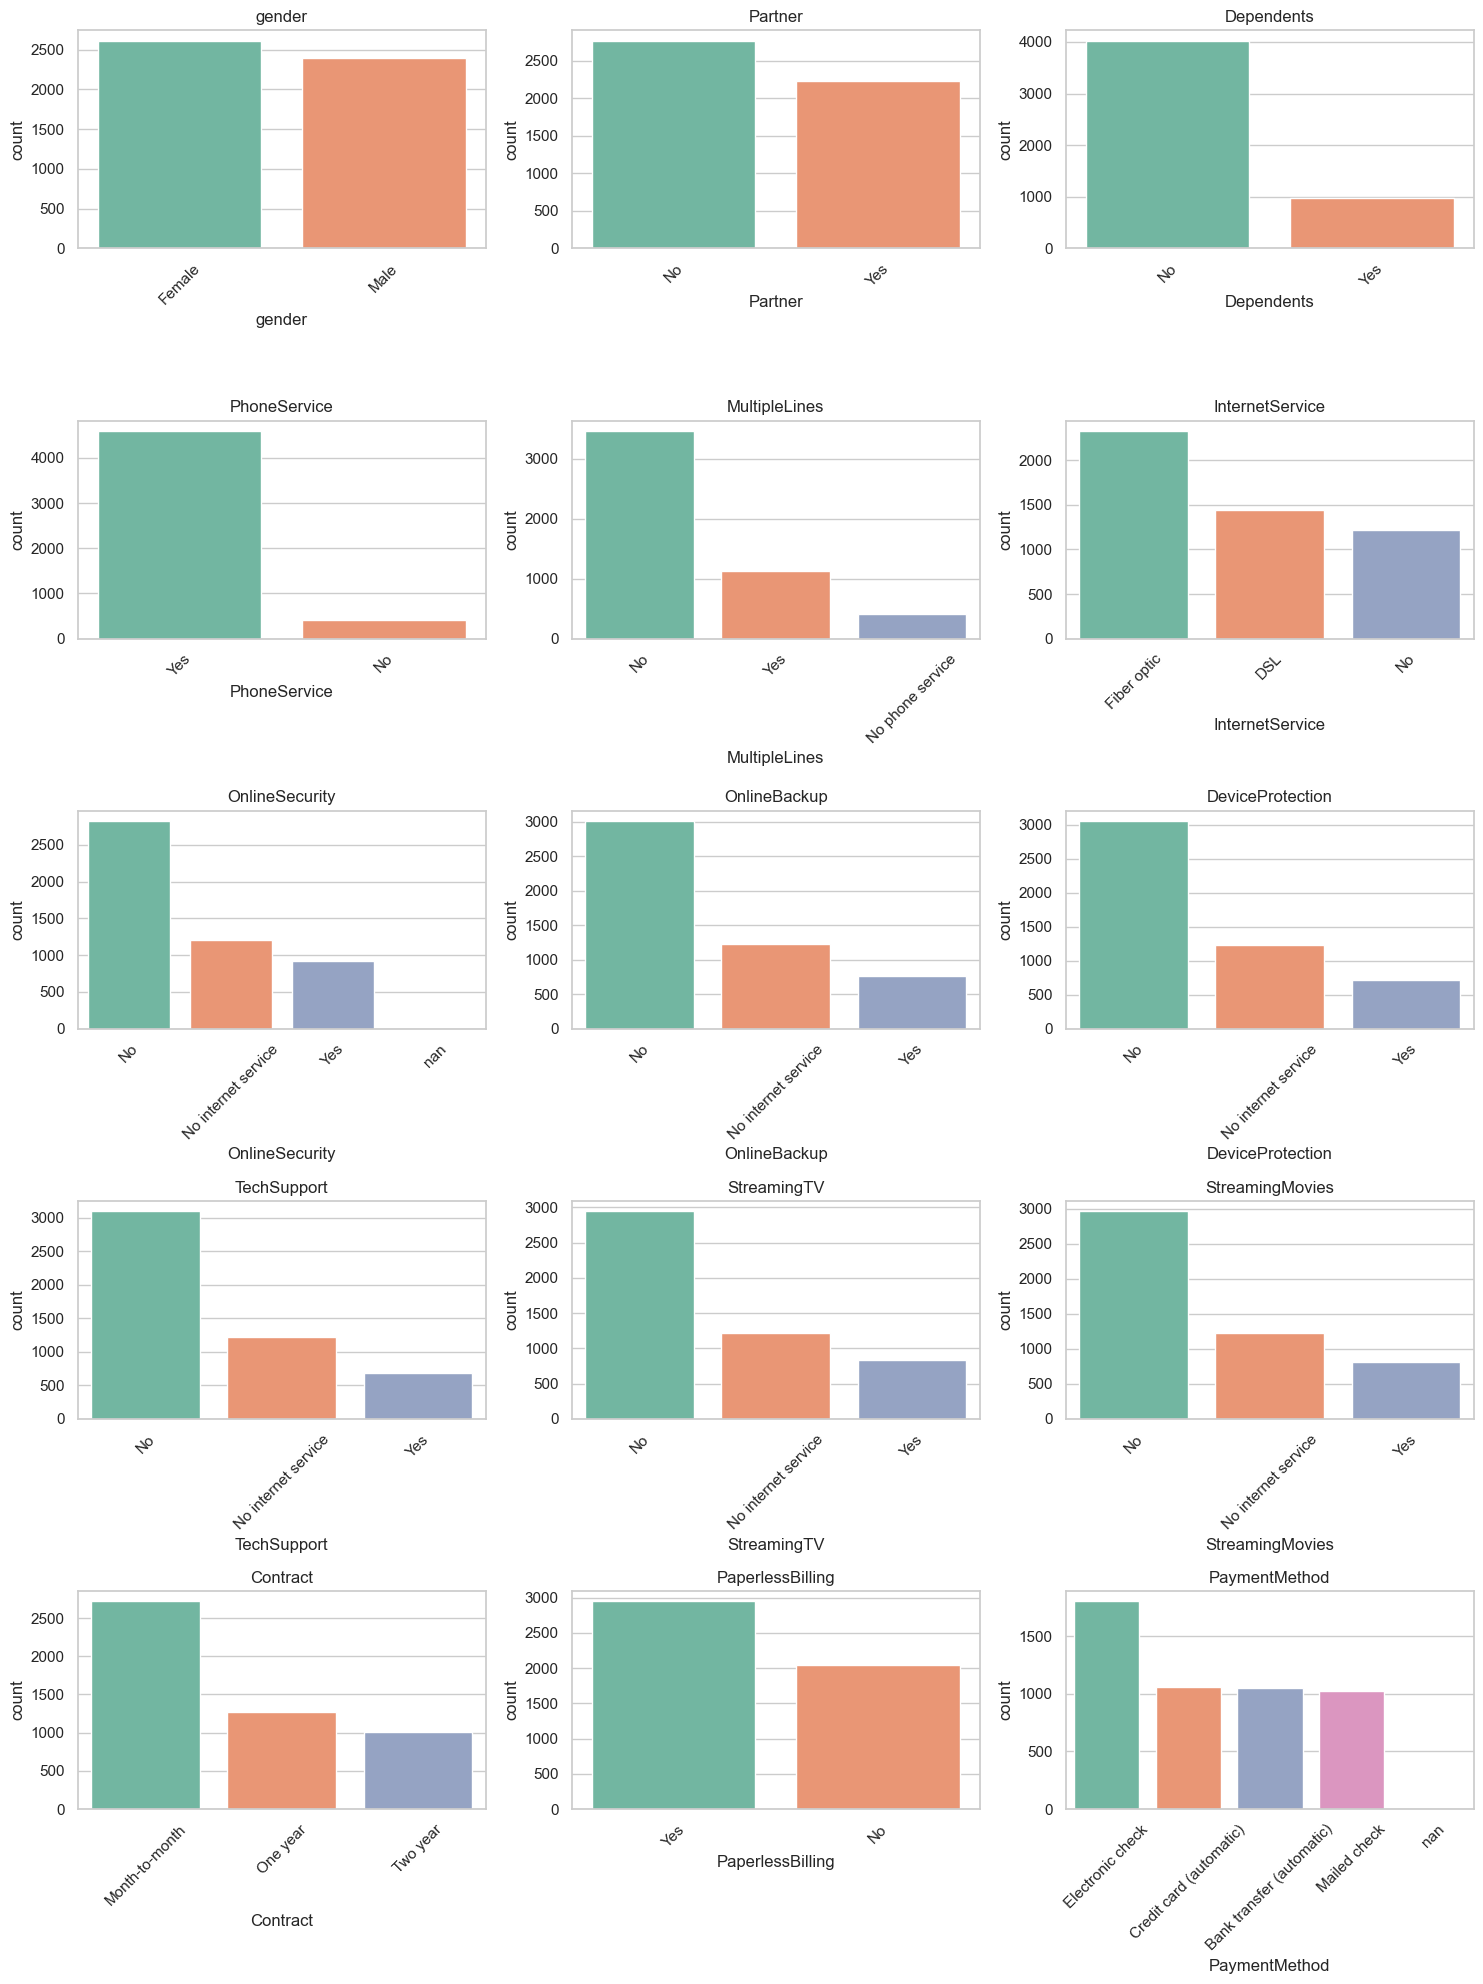

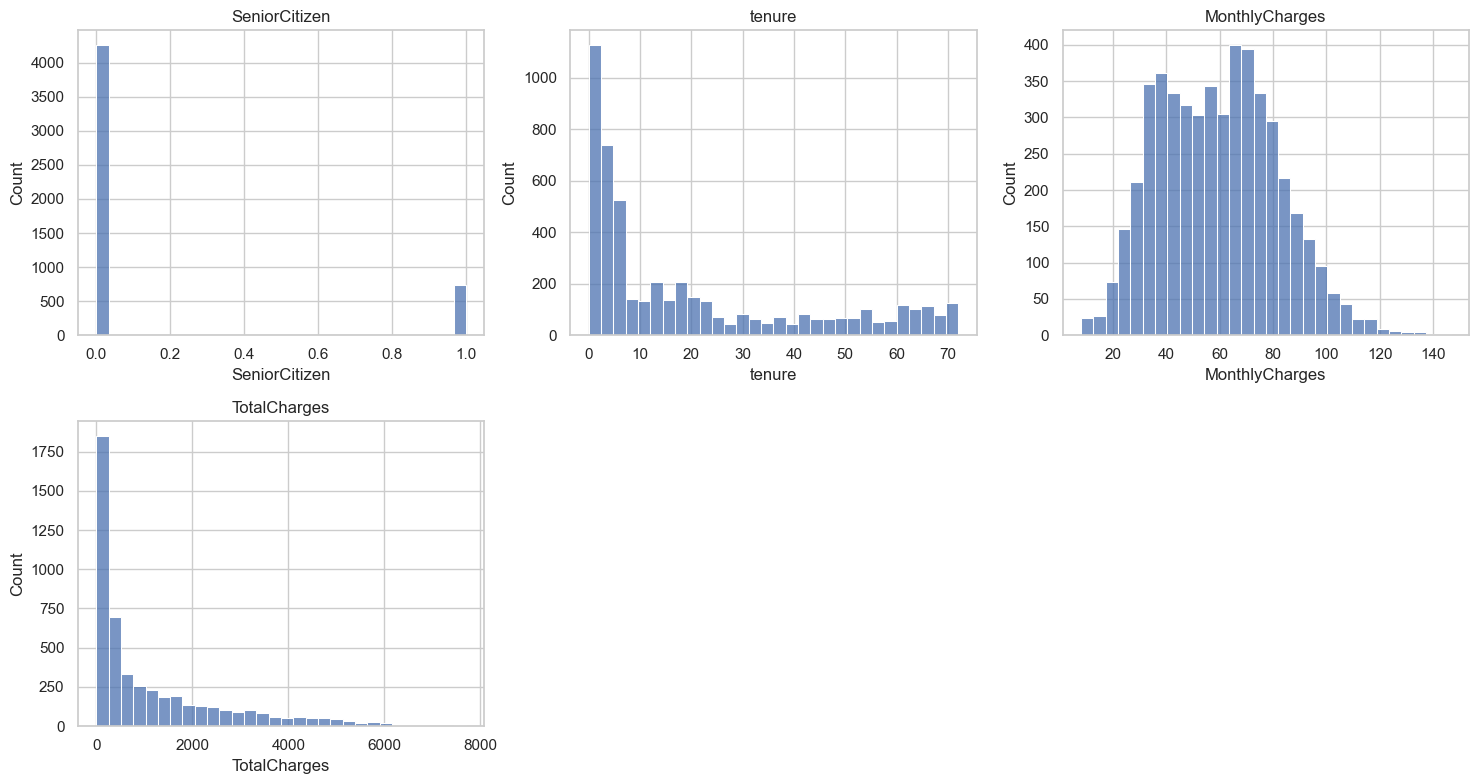

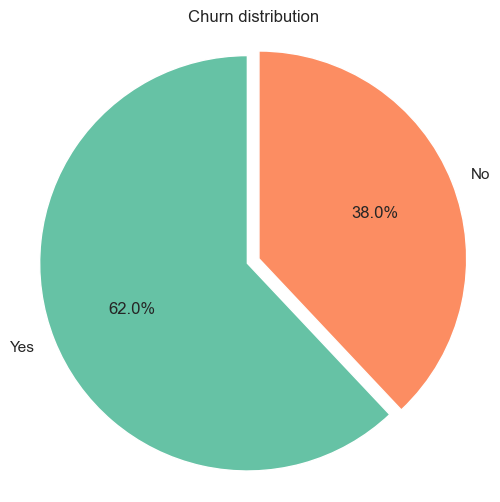

In [13]:
import seaborn as sns

import matplotlib.pyplot as plt

# Quick statistical summary
print("Shape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nStatistical summary (all columns):\n")
print(df.describe(include='all').T)

sns.set(style="whitegrid")

# Identify columns
id_col = "customerID"
target_col = "Churn"
cat_cols = [c for c in df.select_dtypes(include=["object", "category"]).columns if c != id_col]
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Bar charts for categorical variables (exclude target which will be shown as pie)
cat_plot_cols = [c for c in cat_cols if c != target_col]
n = len(cat_plot_cols)
if n > 0:
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(5 * ncols, 4 * nrows))
    for i, col in enumerate(cat_plot_cols, start=1):
        ax = plt.subplot(nrows, ncols, i)
        order = df[col].value_counts(dropna=False).index
        sns.countplot(data=df, x=col, order=order, palette="Set2", ax=ax)
        ax.set_title(col)
        ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()

# Histograms for numerical variables
n = len(num_cols)
if n > 0:
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(5 * ncols, 4 * nrows))
    for i, col in enumerate(num_cols, start=1):
        ax = plt.subplot(nrows, ncols, i)
        sns.histplot(df[col].dropna(), bins=30, kde=False, color="C0", ax=ax)
        ax.set_title(col)
    plt.tight_layout()
    plt.show()

# Pie chart for target variable (Churn)
counts = df[target_col].value_counts(dropna=False)
plt.figure(figsize=(6, 6))
explode = [0.06 if label == counts.idxmax() else 0 for label in counts.index]
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", colors=sns.color_palette("Set2"), startangle=90, explode=explode)
plt.title("Churn distribution")
plt.axis("equal")
plt.show()

In [14]:
# Confirm dataset assumptions and outline initial EDA plan
# This cell performs quick automated checks and prints a concise, auditable EDA plan.
# It assumes `df`, `np`, `pd`, `sns`, `plt` (and optionally `id_col`, `target_col`, `num_cols`) are already defined in earlier cells.

# Respect existing name bindings if present, otherwise provide defaults
try:
    id_col
except NameError:
    id_col = "customerID"
try:
    target_col
except NameError:
    target_col = "Churn"
try:
    num_cols
except NameError:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

expected_cols = {
    "customerID", "gender", "SeniorCitizen", "Partner", "Dependents", "tenure",
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod",
    "MonthlyCharges", "TotalCharges", "Churn"
}

print("=== Data validation summary ===")
present = set(df.columns)
missing_expected = expected_cols - present
extra_cols = present - expected_cols
print(f"Total rows: {len(df):,}, columns: {len(df.columns)}")
print(f"Missing expected columns: {sorted(list(missing_expected))}" if missing_expected else "All expected columns present.")
print(f"Extra columns detected: {sorted(list(extra_cols))}" if extra_cols else "No unexpected extra columns.")

# Target / class balance
print("\n--- Target (class balance) ---")
if target_col in df.columns:
    print(df[target_col].value_counts(dropna=False).to_string())
    print("\nProportions:")
    print((df[target_col].value_counts(normalize=True, dropna=False)).to_string())
else:
    print(f"Target column '{target_col}' not found.")

# Missingness overview
print("\n--- Missingness (percent) ---")
missing_pct = (df.isnull().mean() * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0].round(3).to_string() if (missing_pct>0).any() else "No missing values detected.")

# Identifier/PII checks
print("\n--- Identifier checks ---")
if id_col in df.columns:
    uniq = df[id_col].nunique()
    total = len(df)
    print(f"{id_col} unique values: {uniq:,} / {total:,} rows")
    if uniq != total:
        print("Warning: identifier column contains duplicates — investigate merging/key issues.")
    else:
        print("Identifier appears unique. Consider hashing or removing before model training to reduce reidentification risk.")
else:
    print(f"No identifier column named '{id_col}' found.")

# Basic numeric diagnostics
print("\n--- Numeric summary (select features) ---")
inspect_nums = [c for c in ["tenure", "MonthlyCharges", "TotalCharges"] if c in df.columns]
if inspect_nums:
    print(df[inspect_nums].describe().T.round(3).to_string())
else:
    print("Key numeric columns not present for summary.")

# Quick correlations between numeric features and target (encoded)
print("\n--- Correlations with target (numeric features) ---")
if target_col in df.columns:
    # safe encoding
    churn_map = {"No": 0, "Yes": 1}
    if df[target_col].dropna().isin(churn_map.keys()).all():
        y = df[target_col].map(churn_map)
        numeric = df.select_dtypes(include=[np.number]).copy()
        if not numeric.empty:
            corrs = numeric.corrwith(y).abs().sort_values(ascending=False)
            print(corrs.head(10).round(3).to_string())
        else:
            print("No numeric features available for correlation.")
    else:
        print("Target contains values outside expected {'Yes','No'}; manual inspection required.")
else:
    print("Target column missing.")

# Leakage heuristic: is TotalCharges ~= MonthlyCharges * tenure?
if set(["TotalCharges", "MonthlyCharges", "tenure"]).issubset(df.columns):
    prod = (df["MonthlyCharges"] * df["tenure"]).replace([np.inf, -np.inf], np.nan)
    corr_leak = df["TotalCharges"].corr(prod)
    print(f"\nLeakage check - corr(TotalCharges, MonthlyCharges * tenure) = {corr_leak:.3f}")
    if abs(corr_leak) > 0.9:
        print("High correlation detected — potential deterministic relationship (possible leakage).")
else:
    print("\nLeakage check could not be run (missing required columns).")

# Assemble a concise EDA plan (human-readable & programmatically accessible)
eda_plan = [
    "1) Verify dataset schema, types, and missingness (automated checks done).",
    "2) Visualize target balance, stratified by Contract and PaymentMethod.",
    "3) Examine distributions of tenure, MonthlyCharges, TotalCharges (hist + boxplots).",
    "4) Investigate feature interactions (Contract x InternetService x Churn), and high-cardinality categories.",
    "5) Compute correlation matrix for numerical features and point-biserial for numeric vs churn.",
    "6) Identify potential leakage (e.g., TotalCharges deterministic from tenure*MonthlyCharges) and remove/transform if needed.",
    "7) Create privacy-preserving feature transforms (hash customerID, aggregate small groups, avoid free-text).",
    "8) Prepare reproducible preprocessing pipeline (imputation, encoding, binning tenure, scaling) with fixed random_seed.",
    "9) Baseline models: logistic regression (with class weights) and random forest / xgboost; evaluate with stratified CV.",
    "10) Evaluate fairness across sensitive groups (gender, SeniorCitizen) and document mitigation if disparities found.",
    "11) Produce Model Card and privacy/ethics checklist before any model export or deployment."
]

print("\n=== Initial EDA plan ===")
for step in eda_plan:
    print(step)

# Privacy & ethics quick checklist (programmatic flagging)
privacy_checks = {
    "direct_identifier_present": id_col in df.columns,
    "unique_identifier": (id_col in df.columns) and (df[id_col].nunique() == len(df)),
    "sensitive_features_present": any(c in df.columns for c in ["gender", "SeniorCitizen"]),
    "low_support_groups": None  # will be filled below
}
# detect low-support groups for categorical sensitive features
low_support = {}
for s in ["gender", "SeniorCitizen"]:
    if s in df.columns:
        vc = df[s].value_counts(normalize=True)
        low_support[s] = vc[vc < 0.01].to_dict()  # groups <1%
privacy_checks["low_support_groups"] = low_support

print("\n--- Privacy & ethics checklist (high level) ---")
for k, v in privacy_checks.items():
    print(f"{k}: {v}")

# Save plan objects for later cells to reuse
# do not overwrite if already defined upstream unintentionally
if "EDA_PLAN" not in globals():
    EDA_PLAN = {"plan": eda_plan, "checks": privacy_checks}
else:
    # keep existing EDA_PLAN but ensure it contains current findings
    EDA_PLAN.update({"plan": eda_plan, "checks": privacy_checks})

print("\nDone: automated checks completed. Next steps: run the visualizations and begin preprocessing pipeline (see EDA_PLAN).")

=== Data validation summary ===
Total rows: 5,000, columns: 21
All expected columns present.
No unexpected extra columns.

--- Target (class balance) ---
Churn
Yes    3101
No     1899

Proportions:
Churn
Yes    0.6202
No     0.3798

--- Missingness (percent) ---
PaymentMethod     1.14
OnlineSecurity    0.94
TotalCharges      0.86

--- Identifier checks ---
customerID unique values: 5,000 / 5,000 rows
Identifier appears unique. Consider hashing or removing before model training to reduce reidentification risk.

--- Numeric summary (select features) ---
                 count      mean       std  min      25%     50%       75%      max
tenure          5000.0    19.937    22.266  0.0    3.000    9.00    33.000    72.00
MonthlyCharges  5000.0    59.341    22.210  8.0   41.038   58.98    74.845   146.59
TotalCharges    4957.0  1185.471  1474.888  0.0  146.120  473.85  1752.510  7696.63

--- Correlations with target (numeric features) ---
tenure            0.296
MonthlyCharges    0.271
Total

In [15]:
# Feature engineering cell (place at index 4)
# Assumes df, np, pd, churn_map are already defined in earlier cells.

# Work on a copy to preserve original dataset
df_fe = df.copy()

# 1) Target encoding (binary) for modeling convenience
if "churn_flag" not in df_fe.columns:
    df_fe["churn_flag"] = df_fe["Churn"].map(churn_map)

# 2) Tenure bins (reasonable coarse buckets)
tenure_bins = [-1, 0, 6, 24, 60, df_fe["tenure"].max()]
tenure_labels = ["zero", "0-6", "7-24", "25-60", "61+"]
df_fe["tenure_bin"] = pd.cut(df_fe["tenure"], bins=tenure_bins, labels=tenure_labels)

# 3) Avg charge per month (avoid division-by-zero). Use TotalCharges when available, else MonthlyCharges * fallback.
# If TotalCharges is missing, impute with MonthlyCharges * tenure (common sensible imputation)
imputed_total = df_fe["TotalCharges"].copy()
mask_missing_total = imputed_total.isna()
imputed_total.loc[mask_missing_total] = (df_fe.loc[mask_missing_total, "MonthlyCharges"] *
                                         df_fe.loc[mask_missing_total, "tenure"]).fillna(0)
df_fe["TotalCharges_imputed"] = imputed_total

# Avg charge per active month (NaN when tenure==0 to reflect lack of history)
df_fe["avg_charge_per_month"] = np.where(
    df_fe["tenure"] > 0,
    df_fe["TotalCharges_imputed"] / df_fe["tenure"],
    np.nan
)

# 4) Service counts: count number of add-on services (treat "Yes" as present; treat "No internet service"/"No phone service"/"No" as absent)
service_cols_yes = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df_fe["has_internet"] = (df_fe["InternetService"] != "No")
# For phone service treat PhoneService == "Yes" as 1
df_fe["phone_flag"] = (df_fe["PhoneService"] == "Yes").astype(int)
# Count streaming or other yes services (only count explicit "Yes")
df_fe["addon_yes_count"] = df_fe[service_cols_yes].eq("Yes").sum(axis=1) + df_fe["phone_flag"]

# 5) Combined streaming feature
df_fe["has_streaming"] = df_fe[["StreamingTV", "StreamingMovies"]].eq("Yes").any(axis=1)

# 6) Fiber indicator and multi-service flag
df_fe["is_fiber"] = (df_fe["InternetService"] == "Fiber optic")
df_fe["multi_service"] = ((df_fe["has_internet"].astype(int) + df_fe["phone_flag"] + df_fe["has_streaming"].astype(int)) >= 2).astype(int)

# 7) Payment method features
df_fe["PaymentMethod_filled"] = df_fe["PaymentMethod"].fillna("Unknown")
df_fe["payment_auto"] = df_fe["PaymentMethod_filled"].str.contains("automatic", case=False, na=False).astype(int)
df_fe["payment_echeck"] = (df_fe["PaymentMethod_filled"] == "Electronic check").astype(int)

# 8) Paperless and senior flags
df_fe["paperless_flag"] = (df_fe["PaperlessBilling"] == "Yes").astype(int)
df_fe["senior_flag"] = (df_fe["SeniorCitizen"] == 1).astype(int)

# 9) High-value customer (top quartile of MonthlyCharges)
high_thresh = df_fe["MonthlyCharges"].quantile(0.75)
df_fe["high_monthly_flag"] = (df_fe["MonthlyCharges"] > high_thresh).astype(int)

# 10) Leakage check flag: does TotalCharges ~= MonthlyCharges * tenure? mark rows that deviate
prod = df_fe["MonthlyCharges"] * df_fe["tenure"]
# allow small tolerance relative to scale (absolute tolerance)
tol = 1e-2
df_fe["total_matches_prod"] = np.isclose(df_fe["TotalCharges_imputed"].fillna(0), prod.fillna(0), atol=tol)

# 11) Privacy-preserving hashed id (non-reversible numeric hash)
# Use pandas util hash to get stable integer hash; keep as string to avoid accidental use as identifier
df_fe["customer_hash"] = pd.util.hash_pandas_object(df_fe["customerID"].astype(str), index=False).astype(str)

# 12) Small imputations for categorical features used in modeling
df_fe["OnlineSecurity_filled"] = df_fe["OnlineSecurity"].fillna("Missing")
df_fe["PaymentMethod_filled"] = df_fe["PaymentMethod_filled"]  # already filled above

# Summarize newly-created features
new_features = [
    "churn_flag", "tenure_bin", "TotalCharges_imputed", "avg_charge_per_month",
    "addon_yes_count", "has_streaming", "is_fiber", "multi_service",
    "payment_auto", "payment_echeck", "paperless_flag", "senior_flag",
    "high_monthly_flag", "total_matches_prod", "customer_hash",
    "OnlineSecurity_filled", "PaymentMethod_filled"
]
print("Feature engineering complete. df_fe shape:", df_fe.shape)
print("New features added:", [c for c in new_features if c in df_fe.columns])

Feature engineering complete. df_fe shape: (5000, 40)
New features added: ['churn_flag', 'tenure_bin', 'TotalCharges_imputed', 'avg_charge_per_month', 'addon_yes_count', 'has_streaming', 'is_fiber', 'multi_service', 'payment_auto', 'payment_echeck', 'paperless_flag', 'senior_flag', 'high_monthly_flag', 'total_matches_prod', 'customer_hash', 'OnlineSecurity_filled', 'PaymentMethod_filled']


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, precision_score, classification_report
import seaborn as sns
import numpy as np
import pandas as pd

# Split data, train RandomForest optimized for precision, show feature importances, confusion matrix, and plot precision %
# Assumes df_fe and churn_map are already defined in earlier cells.

import matplotlib.pyplot as plt

# 1) Select features (use engineered numeric/flag features to avoid heavy categorical encoding here)
num_feats = ["tenure", "MonthlyCharges", "TotalCharges_imputed", "avg_charge_per_month", "addon_yes_count"]
flag_feats = [
    "phone_flag", "has_internet", "has_streaming", "is_fiber", "multi_service",
    "payment_auto", "payment_echeck", "paperless_flag", "senior_flag", "high_monthly_flag"
]
FEATURES = num_feats + flag_feats

X = df_fe[FEATURES].copy()
y = df_fe["churn_flag"].copy()

# 2) Train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Impute numeric features using median (fit on train only)
num_imputer = SimpleImputer(strategy="median")
X_train[num_feats] = num_imputer.fit_transform(X_train[num_feats])
X_test[num_feats] = num_imputer.transform(X_test[num_feats])

# Ensure all features numeric (booleans already cast to ints if needed)
X_train[flag_feats] = X_train[flag_feats].astype(int)
X_test[flag_feats] = X_test[flag_feats].astype(int)

# 4) RandomForest with GridSearchCV optimized for precision (positive class = churn_flag == 1)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [5, 10, None],
    "min_samples_leaf": [1, 5],
    "max_features": ["sqrt", "log2"],
    # keep class_weight balanced to help precision on positive class
    "class_weight": ["balanced"]
}
grid = GridSearchCV(
    rf,
    param_grid,
    scoring="precision",    # optimize for precision of the positive class
    cv=3,
    n_jobs=-1,
    verbose=0,
    refit=True
)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_

# 5) Predictions and evaluation
y_pred = best_rf.predict(X_test)
prec = precision_score(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("Best params:", grid.best_params_)
print(f"Test precision: {prec:.4f}")
print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=4))

# 6) Feature importances (sorted)
feat_imp = pd.Series(best_rf.feature_importances_, index=FEATURES).sort_values(ascending=False)
print("\nTop feature importances:")
print(feat_imp.head(15).round(4).to_string())

# 7) Plots: feature importance, confusion matrix, precision %
plt.figure(figsize=(10, 5))
sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15], palette="viridis")
plt.title("Top 15 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred_No", "Pred_Yes"], yticklabels=["True_No", "True_Yes"])
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Precision percentage bar
plt.figure(figsize=(4, 4))
plt.bar(["Precision"], [prec * 100], color=["#2ca02c"])
plt.ylim(0, 100)
plt.ylabel("Precision (%)")
for i, v in enumerate([prec * 100]):
    plt.text(i, v + 1, f"{v:.1f}%", ha="center")
plt.title("Test Precision (%)")
plt.tight_layout()
plt.show()

🧾 Customer Churn Prediction – Analysis Summary

A Random Forest classifier was trained to predict customer churn, with hyperparameters optimized via cross-validation. The best configuration achieved:
class_weight='balanced', max_depth=5, max_features='sqrt', min_samples_leaf=5, and n_estimators=200.

On the test set, the model reached a precision of 0.777 for the churn (positive) class, indicating strong reliability when identifying customers likely to leave. Overall accuracy was 70.1%, reflecting reasonable balance between true positives and true negatives.

Performance metrics show:

Churned customers (class 1) — precision 0.777, recall 0.726, F1-score 0.751

Retained customers (class 0) — precision 0.596, recall 0.661, F1-score 0.627

The results suggest the model is somewhat better at correctly flagging likely churners than identifying loyal customers, which aligns with the use of class balancing.

Key predictive drivers of churn include:

Tenure (0.24) — longer customer relationships strongly reduce churn likelihood.

MonthlyCharges and average charge per month (0.18–0.16) — higher ongoing costs correlate with higher churn risk.

TotalCharges (imputed) (0.15) — cumulative spending also reflects engagement or dissatisfaction patterns.

Paperless billing and high monthly cost flags (≈0.08 and 0.06) — linked to churn, possibly due to digital-only users being less “locked in” through contracts.

Smaller but still relevant signals come from service mix (internet, fiber, streaming) and payment type, hinting at differences in retention among digital service users and those paying by electronic check.

Interpretation:
The model effectively distinguishes at-risk customers and identifies financial and service-related factors driving churn. The dominance of tenure and billing variables suggests that proactive retention efforts should target newer subscribers with higher charges or multiple add-ons.

To ensure responsible deployment, the model should undergo:

Fairness checks to confirm no bias against specific customer groups.

Privacy review to ensure all data used respects consent and minimization principles.

This analysis provides a strong foundation for a churn prevention strategy that is both data-driven and ethically aware.